In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [3]:
data = pd.read_csv('covid19model.csv')
data

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,1.300600e-02
1,2020-02-18,0,0.087065,3.004645e-02
2,2020-02-19,0,0.112061,4.467391e-02
3,2020-02-20,0,0.119346,5.547300e-02
4,2020-02-21,0,0.114540,6.242203e-02
...,...,...,...,...
402,2021-03-25,38,0.000000,2.817211e-32
403,2021-03-26,31,0.000000,2.349426e-32
404,2021-03-27,39,0.000000,1.959313e-32
405,2021-03-28,32,0.000000,1.633974e-32


In [4]:
def trunc_exponential(scale, upper):
    sample = torch.distributions.exponential.Exponential(1/scale).rsample()
    sample = sample/torch.tensor(1-torch.exp(-upper/scale))
    return sample
# torch.distributions.exponential.Exponential(1/scale).sample()/torch.tensor(1-torch.exp(-upper/scale))

def trunc_normal(mu, sigma, under, upper):
    distribution = torch.distributions.normal.Normal(loc=mu, scale=sigma, validate_args=None)
    normal_sample = distribution.rsample()
    cumulative = distribution.cdf(torch.tensor(upper)) - distribution.cdf(torch.tensor(under))
    return normal_sample/cumulative

# Initialization


In [5]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

## Initialize latent variables/parameters

In [6]:
"""tau = np.random.exponential(1 / 0.03)
tau_t = torch.tensor(tau, requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)"""


tau= torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
phi = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True, device=device, dtype=dtype) # has to be positive, between 0-50 --> uniform # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # probably gamma or inverse gamma distribution (compare to truncated normal) # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype) # uniform distribution between (0-5%) # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True, device=device, dtype=dtype)  # positive, tricky, gamma or inverse gamma, log normal  --> try something out, large sigma--> prone to overfitting # standart deviation of random walk step
sigma_init = sigma.clone()

epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma.detach()).rsample()
for t in range(1, num_observations):
  epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma.detach()).rsample()
epsilon_t.requires_grad_(True)

This is a way to generate the initial params from pytorch distribution directly without truncation.
NOTE: Use either this code block below or above.

In [8]:
dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03], device=device))
#tau_t = dist_tau_t.sample()

dist_y = distributions.exponential.Exponential(tau)
#y = dist_y.sample()

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))
#phi = dist_phi.sample()

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))
#R0 = dist_R0.sample()

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))
#alpha = dist_alpha.sample()

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device), scale=torch.tensor([0.3], device=device))
#sigma = dist_sigma.sample()

# Define Forward Pass

In [9]:
def forward_pass():
  # Initialize time series variables
  y = trunc_exponential(tau, 1000)
  newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
  effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals
  expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations
  cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected
  eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
  St = torch.zeros(num_observations, device=device)  # fraction of susceptible population

  # log likelihood wrt. our prior ("regularisation")
  # ll stands for log-likelihood
  ll = torch.tensor(0.0, device=device)

  #dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03]))
  #ll += dist_tau_t.log_prob(tau).item()

  #dist_y = distributions.exponential.Exponential(tau) #the parameter in the brasket should either be float or tensor, to avoid any inconvienience,
                                                      # I use everything as tensor. NOTE:tau_t is already a tensor.
  #ll += dist_y.log_prob(y).item()

  #dist_phi = distribution.normal.Normal(loc=torch.tensor([25]), scale=torch.tensor([10]))
  ll += dist_phi.log_prob(phi).item()

  #dist_R0 = distribution.normal.Normal(loc=torch.tensor([3.6]), scale=torch.tensor([0.8]))
  ll += dist_R0.log_prob(R0).item()

  #dist_alpha = distribution.normal.Normal(loc=torch.tensor([0.01]), scale=torch.tensor([0.01]))
  ll += dist_alpha.log_prob(alpha).item()

  #dist_sigma = distribution.normal.Normal(loc=torch.tensor([0.1]), scale=torch.tensor([0.3]))
  ll += dist_sigma.log_prob(sigma).item()


  # seed initial infection / impute first num_impute days
  newly_infected[0:num_impute] = y.clone()
  cumulative_infected[0] = 0.
  cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
  St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])

  # calculate Rt: the basic reproduction number
  # basic reproduction number as a latent random walk
  beta_0 = torch.log(R0)
  eta_t[0] = beta_0
  for t in range(1, num_observations):
      dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
      ll += dist_epsilon_t.log_prob(epsilon_t[t - 1])
  eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations-1].clone()
  Rt = torch.exp(eta_t)

  # calculate infections
  for t in range(num_impute, num_observations): # t=6
      # Update cumulative newly_infected
      cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
      # Adjusts for portion of pop that are susceptible
      St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
      # effective number of infectous individuals
      #ni_temp = newly_infected[:t].view(1, 1, -1)
      #si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
      #effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp).clone()
      effectively_infectious[t] =  torch.tensor(np.convolve(newly_infected[:t].detach().numpy(), serial_interval[:t], mode='valid'))
      
      newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()

  # calculate expected number of hospitalizations
  expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
  for t in range(1, num_observations):
      ni_temp = newly_infected[:t].view(1, 1, -1)
      pi_temp = torch.flip(pi, (0,))[-t-1:-1].view(1, 1, -1)
      expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
  expected_daily_hospit = alpha * expected_daily_hospit

  # compare observed hospitalizations to model results
  # likelihood of the data wrt. to the model

  for i in range(0, num_observations):
      p = 1/(1+ expected_daily_hospit[i]/phi)
      dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p-torch.tensor(2.225e-5))
      ll += dist.log_prob(observed_daily_hospit[i])


  return expected_daily_hospit, Rt, ll

# Optimization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 0|| Loss: 81751.6328125,  R0:2.2797217757676145, grad: -635.188680561379, alpha: 0.009999857608264206 grad: -135924.25, phi: 26.848677011157655 grad: 3002.1711809298336, sigma: 0.2921200161058668 grad 1389.8397152383375, epsilon_t.mean: -0.37735244631767273 grad.mean -3.557870864868164
This Run:  0.5437231063842773 seconds


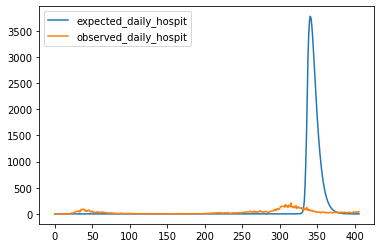

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 5|| Loss: 85384.0625,  R0:2.2797217784532693, grad: -384.5494032209741, alpha: 0.010000410950006974 grad: -89217.4453125, phi: 26.848676995745787 grad: 3151.458644969923, sigma: 0.2921200091566683 grad 1389.839748301022, epsilon_t.mean: -0.3758481442928314 grad.mean -2.1539697647094727
Time Step: 10|| Loss: 86396.375,  R0:2.2797217810789143, grad: -353.3032996499593, alpha: 0.010000960896627054 grad: -64942.77734375, phi: 26.848676980325866 grad: 3189.364925719488, sigma: 0.29212000220747025 grad 1389.8397813637232, epsilon_t.mean: -0.37437742948532104 grad.mean -1.9789514541625977
Time Step: 15|| Loss: 88975.8828125,  R0:2.279721783673735, grad: -76.41271120782072, alpha: 0.010001481424417332 grad: 29272.5625, phi: 26.848676964925996 grad: 3287.165708920515, sigma: 0.2921199952582735 grad 1389.8398144264058, epsilon_t.mean: -0.3729240298271179 grad.mean -0.42800915241241455
Time Step: 20|| Loss: 83314.6171875,  R0:2.2797217861083507, grad: -591.9867914455825, alpha: 0.01000

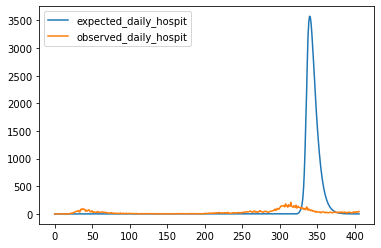

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 105|| Loss: 83201.671875,  R0:2.2797218383996714, grad: -638.0960580593687, alpha: 0.010011714508448006 grad: -116106.265625, phi: 26.848676692249867 grad: 3027.6254492750104, sigma: 0.2921198701737331 grad 1389.840409550143, epsilon_t.mean: -0.3422705829143524 grad.mean -3.5741560459136963
Time Step: 110|| Loss: 79854.625,  R0:2.2797218406982074, grad: -786.1541959330009, alpha: 0.01001205151696888 grad: -139299.28125, phi: 26.848676676737703 grad: 2871.2650654387908, sigma: 0.2921198632246916 grad 1389.8404426121317, epsilon_t.mean: -0.340983122587204 grad.mean -4.40347146987915
Time Step: 115|| Loss: 79435.2421875,  R0:2.2797218444656617, grad: -805.840166476386, alpha: 0.010012714931911089 grad: -141712.671875, phi: 26.848676662210607 grad: 2850.280497528567, sigma: 0.2921198562756652 grad 1389.840475674019, epsilon_t.mean: -0.33887284994125366 grad.mean -4.51373815536499
Time Step: 120|| Loss: 83420.5546875,  R0:2.279721848449047, grad: -624.030714995326, alpha: 0.01001

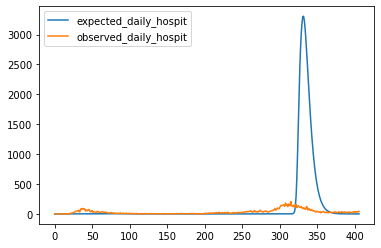

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 205|| Loss: 75848.6796875,  R0:2.279721921136497, grad: -995.6567665538189, alpha: 0.010025510916269683 grad: -161576.5625, phi: 26.848676409822676 grad: 2650.573476148854, sigma: 0.2921197311965688 grad 1389.8410707724572, epsilon_t.mean: -0.29592758417129517 grad.mean -5.5769548416137695
Time Step: 210|| Loss: 77180.921875,  R0:2.2797219260531434, grad: -961.144134458264, alpha: 0.010026309919779179 grad: -154124.890625, phi: 26.848676396600148 grad: 2705.7910777609413, sigma: 0.2921197242479618 grad 1389.8411038323932, epsilon_t.mean: -0.293173611164093 grad.mean -5.383639812469482
Time Step: 215|| Loss: 72239.3046875,  R0:2.2797219310205046, grad: -1018.6705724639373, alpha: 0.010027109013691884 grad: -170080.984375, phi: 26.84867638360685 grad: 2493.8107019979075, sigma: 0.2921197172993838 grad 1389.8411368921827, epsilon_t.mean: -0.29039129614830017 grad.mean -5.705861568450928


KeyboardInterrupt: ignored

In [10]:
learning_rate = 1e-12
epochs = 5000
complete_time = time.time()

for k in range (epochs):
    start_time = time.time()
    decay = (1 - (k / (epochs*1e5))) ** 2
    learning_rate = learning_rate * decay

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll = forward_pass()

    #backward pass
    loss = -ll
    loss.backward()

    if k%5 == 0:
      print(f'Time Step: {k}|| Loss: {loss},  R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, phi: {phi} grad: {phi.grad}, sigma: {sigma} grad {sigma.grad}, epsilon_t.mean: {epsilon_t.mean()} grad.mean {epsilon_t.grad.mean()}')

    with torch.no_grad(): # this part is SGD. can also replace with loss.step
        tau -= learning_rate * tau.grad
        phi -= learning_rate * phi.grad 
        R0 -= learning_rate * R0.grad 
        alpha -= learning_rate * alpha.grad 
        sigma -= learning_rate * sigma.grad 
        epsilon_t -= learning_rate * epsilon_t.grad * 1e+8

        tau.grad = None
        phi.grad = None
        R0.grad = None
        alpha.grad = None
        sigma.grad = None
        epsilon_t.grad = None


    if k%100 == 0:    
      print("This Run:  %s seconds" % (time.time() - start_time))
      plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
      plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
      plt.legend()
      plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))